<a href="https://colab.research.google.com/github/OliverEvans96/planck-integral/blob/main/NumericalBenchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpmath import mp
from scipy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from tqdm.notebook import tqdm

In [2]:
mp.dps = 50

In [3]:
!git clone https://github.com/OliverEvans96/planck-integral.git

fatal: destination path 'planck-integral' already exists and is not an empty directory.


In [6]:
def plancks_law(nu, T):
  return 2 * const.h * nu**3 / ((mp.exp(const.h * nu / (const.k * T)) - 1) * const.c**2 )

In [7]:
def integrate_planck_dist(T, nu_max):
  return mp.quad(lambda nu: plancks_law(nu, T), [0, nu_max])

In [8]:
def calc_planck_integrals(T, freqs):
  integrals = []
  for freq in tqdm(freqs):
    integral = integrate_planck_dist(T, freq)
    integrals.append(integral)
  return integrals

# Test `mpmath` precision

In [13]:
def test_mpmath_precision(nu, T):
  digits_range = list(range(1, 100))
  integral_vals = []
  for num_digits in digits_range:
    mp.dps = num_digits
    integral = integrate_planck_dist(T, nu)
    integral_vals.append(integral)

  final_ans = integral_vals[-1]
  err_arr = []
  for ans in integral_vals[:-1]:
    err = np.abs(ans - final_ans)
    err_arr.append(err)

  plt.plot(digits_range[:-1], err_arr)
  plt.yscale('log')
  plt.xlabel('requested precision (decimal digits)')
  plt.ylabel('error')
  plt.grid('on')
  plt.show()

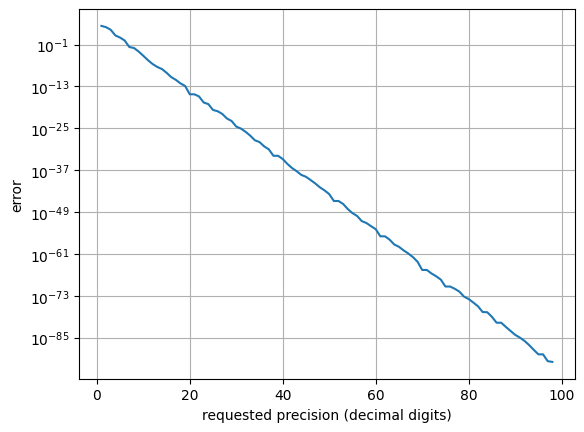

In [15]:
test_mpmath_precision(
  nu = 877253052027857.375, # Hz
  T = 6007, # K
)

# Calculate peak frequency

In [16]:
sp_h, sp_k, sp_c, sp_nu, sp_T = sp.var('h, k, c, nu, T')

In [17]:
def plancks_law_sym(nu, T):
  return 2 * sp_h * nu**3 / ((sp.exp(sp_h * nu / (sp_k * T)) - 1) * sp_c**2 )

In [18]:
crit_eq = sp.Eq(sp.diff(plancks_law_sym(sp_nu, sp_T), sp_nu), 0)
crit_eq

Eq(6*h*nu**2/(c**2*(exp(h*nu/(T*k)) - 1)) - 2*h**2*nu**3*exp(h*nu/(T*k))/(T*c**2*k*(exp(h*nu/(T*k)) - 1)**2), 0)

In [19]:
sp_x = sp.var('x')

In [20]:
crit_eq_x = crit_eq.subs(sp_h*sp_nu/(sp_T*sp_k), sp_x)
crit_eq_x

Eq(-2*h*nu**2*x*exp(x)/(c**2*(exp(x) - 1)**2) + 6*h*nu**2/(c**2*(exp(x) - 1)), 0)

In [21]:
sp.simplify(crit_eq_x)

Eq(2*h*nu**2*(-x*exp(x) + 3*exp(x) - 3)/(c**2*(1 - exp(x))**2), 0)

In [22]:
def peak_eq(x):
  return -x * mp.exp(x) + 3 * mp.exp(x) - 3

In [23]:
def calc_peak_freq(T):
  x_val = mp.findroot(peak_eq, 2.8)
  nu_peak = x_val * const.k * T / const.h
  return nu_peak

In [24]:
def read_data_file(data_path):
  freqs = []
  with open(data_path) as data_file:
    for line in data_file.readlines():
      # strip whitespace
      stripped = line.strip()
      # skip blank lines
      if len(stripped) == 0:
        continue
      # Get frequency from second column
      freq = mp.mpf(line.split()[1])
      freqs.append(freq)
  return freqs

In [25]:
def format_float(val, num_digits):
  """Print a high-precision float with the given number of digits"""
  # set min_fixed and max_fixed to avoid exponential notation
  return mp.nstr(
      val,
      n=num_digits,
      strip_zeros=False,
      min_fixed=-mp.inf,
      max_fixed=mp.inf,
    )

In [33]:
def write_output(filename, freqs, integrals, num_digits):
  with open(filename, 'w', encoding='utf8') as out_file:
    for freq, integral in zip(freqs, integrals):
      freq_formatted = format_float(freq, 18)
      integral_formatted = format_float(integral, num_digits)

      out_file.write(freq_formatted)
      out_file.write(' ')
      out_file.write(integral_formatted)
      out_file.write(' ')
      out_file.write("[ W/m² ] / [ Sr ]")
      out_file.write('\n')


In [34]:
def plot_planck_dist(T):
  nu_arr = list(range(1, int(1e15), int(1e12))) # Hz
  B_arr = np.array([plancks_law(nu, T) for nu in nu_arr])
  B_max = np.max(B_arr)
  nu_peak = float(calc_peak_freq(T))

  plt.plot(nu_arr, B_arr, label=f'Planck(Hz, {T} K)')
  plt.xlabel(r'$\nu$')
  plt.ylabel(r'$B_\nu$')
  plt.vlines([nu_peak], 0, B_max, color='C1', ls='--', label=f'Peak ({nu_peak:.3e} Hz)')
  plt.legend()
  plt.show()

In [35]:
def produce_benchmarks(data_path, T, workdps=50, outdps=25):
  with mp.workdps(workdps):
    plot_planck_dist(T)
    freqs = read_data_file(data_path)
    nu_peak = calc_peak_freq(T)
    # Prepend peak frequency to frequency list
    freqs.insert(0, nu_peak)
    integrals = calc_planck_integrals(T, freqs)
    filename = 'planck_integrals_{}K.dat'.format(T)
    write_output(filename, freqs, integrals, num_digits=25)


# Perform calculations

In [37]:
data_path = 'planck-integral/data/phos.dat'

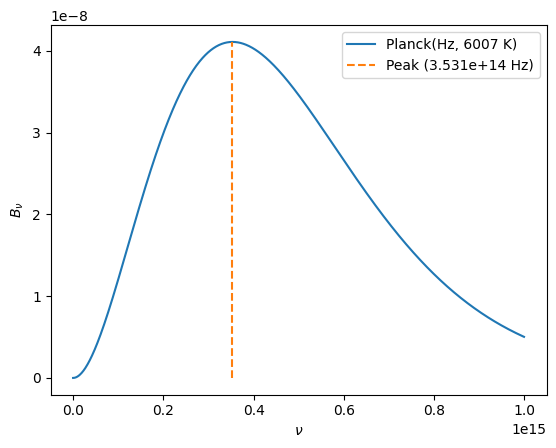

  0%|          | 0/2048 [00:00<?, ?it/s]

In [38]:
produce_benchmarks(data_path, T=6007)

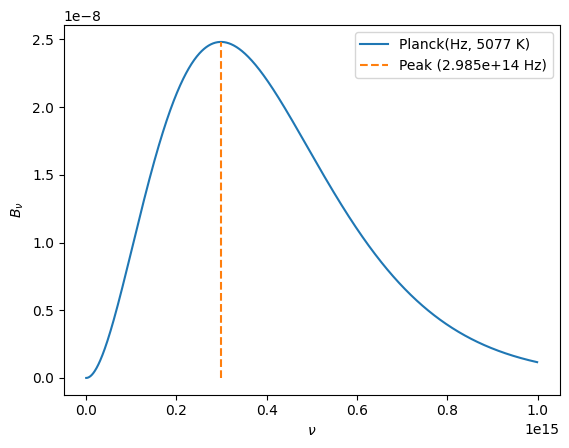

  0%|          | 0/2048 [00:00<?, ?it/s]

In [39]:
produce_benchmarks(data_path, T=5077)